In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
#先reshape变为一维的目的是对每一个像素点进行标准化（让其等价）
#同时StandardScaler只能对二维的进行标准化
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()
#批归一化为了防止梯度消失
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    #只要在模型中加入下面代码即可
    model.add(keras.layers.BatchNormalization())
    """
    #也可以把激活函数放在批归一化的后面
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    """
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [7]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 29s 17ms/step - loss: 1.9027 - accuracy: 0.3695 - val_loss: 0.9806 - val_accuracy: 0.6524
Epoch 2/100
1719/1719 [==============================] - 28s 16ms/step - loss: 1.1040 - accuracy: 0.6127 - val_loss: 0.7917 - val_accuracy: 0.7082
Epoch 3/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.9754 - accuracy: 0.6531 - val_loss: 0.7050 - val_accuracy: 0.7378
Epoch 4/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.9035 - accuracy: 0.6777 - val_loss: 0.6425 - val_accuracy: 0.7678
Epoch 5/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.8431 - accuracy: 0.6963 - val_loss: 0.6093 - val_accuracy: 0.7778
Epoch 6/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.8041 - accuracy: 0.7137 - val_loss: 0.5812 - val_accuracy: 0.7872
Epoch 7/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7651 - accuracy: 0.7252 - val_loss: 0

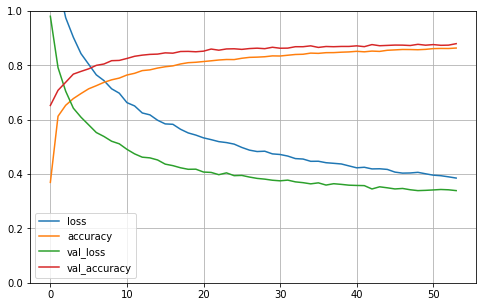

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    批归一化缓解梯度消失

In [9]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.3737739622592926, 0.8647000193595886]